


# How To Use XModalix
X-Modalix is our implementation of a cross modal autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extenisve, because
our pipeline works similar for different architecture, so here we focus only on `X-Modalix` specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Stackix pipeline. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.


## XModalix Theory
The core idead of cross modal autoencoder to align the latent spaces of different data modalities. After fitting such aligned latent distributions, we can translate between different data modalities by feeding data from one modality to its corresponding encoder and then feeding the latent space to the decoder of the target (the modality you want to translate to) modality.

The underlying models are separate VAE's; one for each data modality which are trained in parallel. However, their latent spaces are very closely aligned in a way that data modalities can hardly be discriminated, but sample variation is kept.  
To get an aligned latent space, the loss function to train the VAE's is extended by the following terms and ideas:

- *Adversarial* loss term: in parallel to the VAEs a third neural network (latent space classifier) is trained to discriminate the latent space embeddings of the different data modalities. Analogously to a GAN, the inverse loss of this latent space classifier is used as loss term in addition to the normal VAE loss function to enforce an alignment of latent spaces. <br> <br>
- *Paired* loss term: Latent space alignment is further enforced by minimizing the distance between samples with paired measurements of each data modality. In our current implementation, we allow also unpaired samples, to get sensible results, we recomment the majority of samples to be paired (present in all data modalities). <br> <br>
- *Class-based* loss term: This is a semi-supervised training loss term can be used, which minimizes distance among each class of samples. A class memebership of a sample is defined in the annotation data and can be something like a cancer type, or cell type, etc. In each iteration we calculate a class mean of all samples of a class in the latent space.  Subsequently we calculate the distance between a sample of this class and the class mean. See our `Preprint [TODO]` for more details. <br> <br>


---
## What You'll Learn

As a showcase for data modality translation by `x-modalix`, we will use cancer gene expression from TCGA as in combination with handwritten digits from the [MNIST data set](https://keras.io/api/datasets/mnist/).  
Our goal is to translate the gene expression signature of five selected cancer subtypes to images of digits, where each cancer subtype class is assigned to a digit between 0-4:  

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/729f3e8172a722e7c3681298719d9d4b59e313d9/images/xmodalix_scheme.svg" alt="ontix-ontologies" width="1200"/>
In practice those images can be histopathological images or any other data modality. Before we show data preparation and `x-modalix` training, some background to the basic idea of a cross-modal VAE as proposed by [Yang & Uhler](https://arxiv.org/abs/1902.03515). 


While following the showcase you learn how to:

1. **Initialize** pipeline and run the pipeline. <br> <br>
2. Understand the X-Modalix sepecific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access the X-Modalix specific **results** (sub-results for modality autoencoders). <br><br>
4. **Visualize** outputs. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 



## 1) Initialize and Run XModalix
In this case we read our input data from files. We define the file locations in our config. This is done via a part of the config object, called DataConfig (see details Python code below).  
We go over a few custom config parameters for `XModalix`. For a deep dive into the config object see [1]
- `pretrain_epochs`: Before training the whole `X-Modalix`, we can pretrain the sub VAEs of each modality. This param can be set globally for all data modalities or individually per data modality. It specifies the number of epochs of the pretraining. 
- `gamma`: Hyperparameter to weight adversarial loss term.
- `delta_pair`: Hyperparameter to weight paired loss term.
- `delta_class`: Hyperparameter to weight class loss term.

### Extra 1: Getting Tutorial Data
You can run these bash commands to get the data and have the correct path **We assume you're in the root of autoencodix_package**
```bash
mkdir -p data
cd data
wget "https://cloud.scadsai.uni-leipzig.de/index.php/s/rSMzzJLsiwDRWgW/download/XModalix-Tut-data.zip" 
unzip  XModalix-Tut-data.zip -d XModalix-Tut-data
```

### Extra 2: Get correct path
We assume to be in root of our package, the following code makes sure we are.
[1] Tutorials/DeepDives/ConfigTutorial.ipynb

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /Users/maximilianjoas/development/autoencodix_package


In [2]:
# import pandas as pd

# anno = pd.read_csv(anno_file, sep="\t")
# rna = pd.read_parquet(rna_file)
# clin = pd.read_parquet(clin_file)
# print(anno.shape)
# print(rna.shape)
# clin.head()

In [5]:
import os
import autoencodix as acx

from autoencodix.configs.xmodalix_config import XModalixConfig
from autoencodix.configs.default_config import DataConfig, DataInfo, DataCase

imganno_file = os.path.join("data/XModalix-Tut-data/tcga_mappings.txt")
rna_file = os.path.join("data/XModalix-Tut-data/combined_rnaseq_formatted.parquet")
img_root = os.path.join("data/XModalix-Tut-data/images/tcga_fake")
clin_file = os.path.join("data/XModalix-Tut-data/combined_clin_formatted.parquet")


xmodalix_config = XModalixConfig(
    checkpoint_interval=5,
    class_param="CANCER_TYPE_ACRONYM",
    epochs=3,
    beta=0.01,
    gamma=2,
    delta_class=0.0,
    delta_pair=3.0,
    latent_dim=8,
    requires_paired=True,
    data_case=DataCase.IMG_TO_BULK,
    data_config=DataConfig(
        data_info={
            "img": DataInfo(
                file_path=img_root,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=3,
                extra_anno_file=imganno_file,
            ),
            "rna": DataInfo(
                file_path=rna_file,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "anno": DataInfo(file_path=clin_file, data_type="ANNOTATION", sep="\t"),
        },
    ),
)

xmodalix = acx.XModalix(config=xmodalix_config)


In [6]:
xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
reading parquet: data/XModalix-Tut-data/combined_clin_formatted.parquet
Given image size is possible, rescaling images to: 64x64


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:264: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


Successfully loaded 3230 images for img
anno key: paired
anno key: img
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  paired: 3552 samples × 54 features
  img: 3230 samples × 3 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  paired: 3552 samples × 54 features
  img: 3230 samples × 3 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
DP:
multi_bulk:
  rna: 3552 samples × 17450 features
annotation:
  paired: 3552 samples × 54 features
  img: 3230 samples × 3 features
img:
  img: 3230 items
k: multi_sc
k: multi_bulk
k: annotation
k: img
k: from_modality
k: to_modality
Converting 2261 images to torch.float32 tensors...
Converting 646 images to torch.float32 tensors...
Converting 323 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
k

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'total_loss': TrainingDynamics(), 'adver_loss': TrainingDynamics(), 'aggregated_sub_losses': TrainingDynamics(), 'paired_loss': TrainingDynamics(), 'class_loss': TrainingDynamics(), 'multi_bulk.rna.recon_loss': TrainingDynamics(), 'multi_bulk.rna.var_loss': TrainingDynamics(), 'multi_bulk.rna.anneal_factor': TrainingDynamics(), 'multi_bulk.rna.effective_beta_factor': TrainingDynamics(), 'multi_bulk.rna.loss': TrainingDynamics(), 'img.img.recon_loss': TrainingDynamics(), 'img.img.var_loss': TrainingDynamics(), 'img.img.anneal_factor': TrainingDynamics(), 'img.img.effective_beta_factor': TrainingDynamics(), 'img.img.loss': TrainingDynamics(), 'clf_loss': TrainingDynamics()})
preprocessed

Creating plots ...


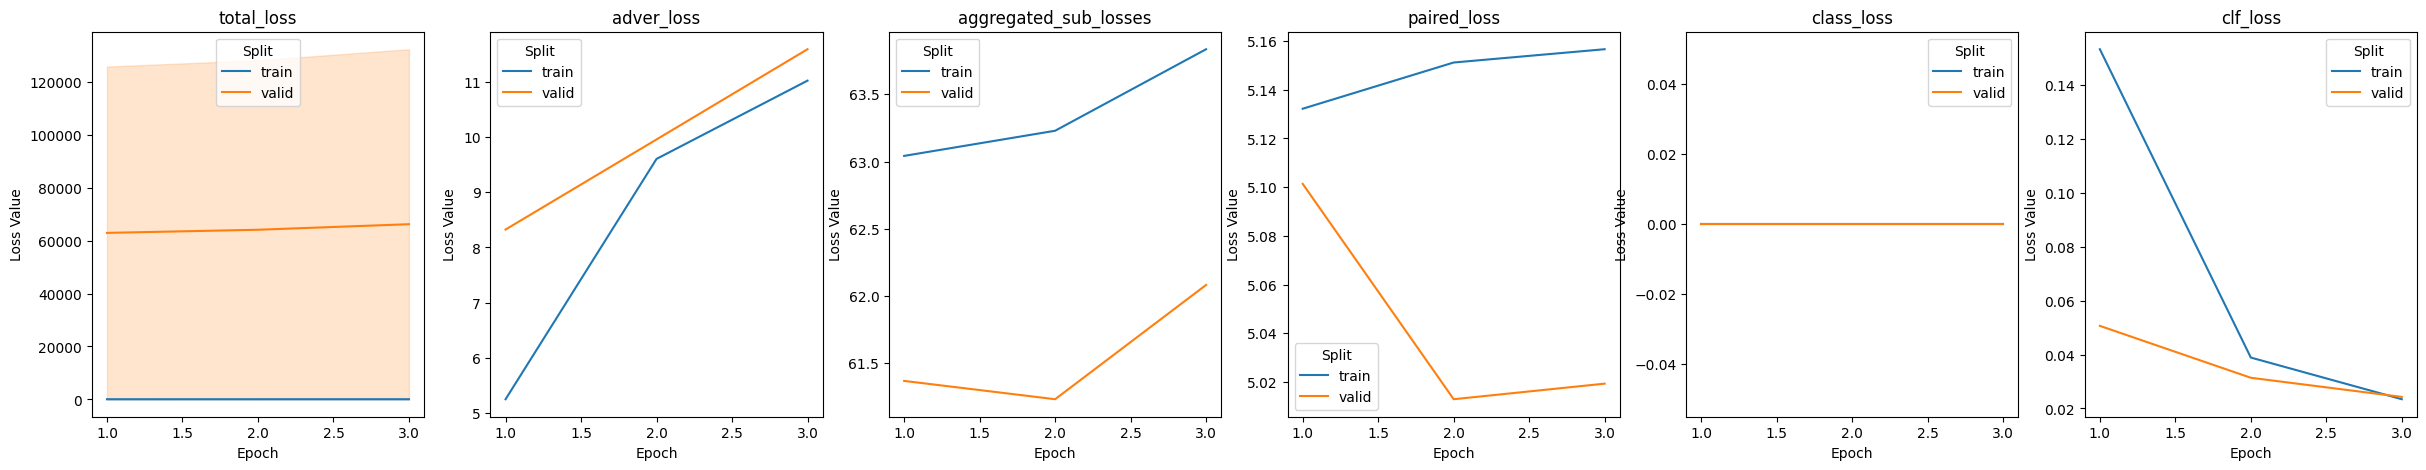

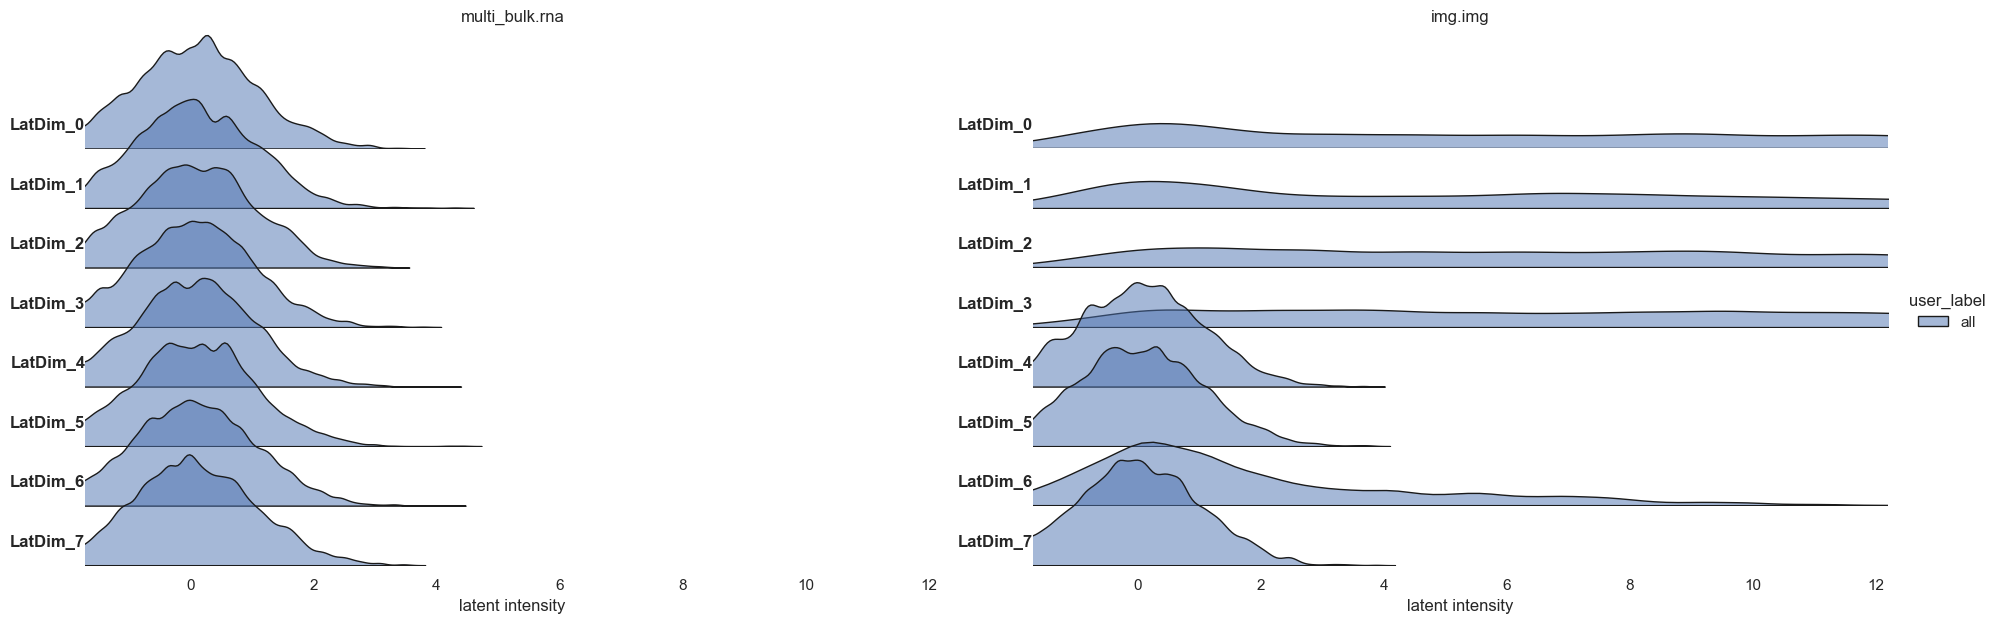

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


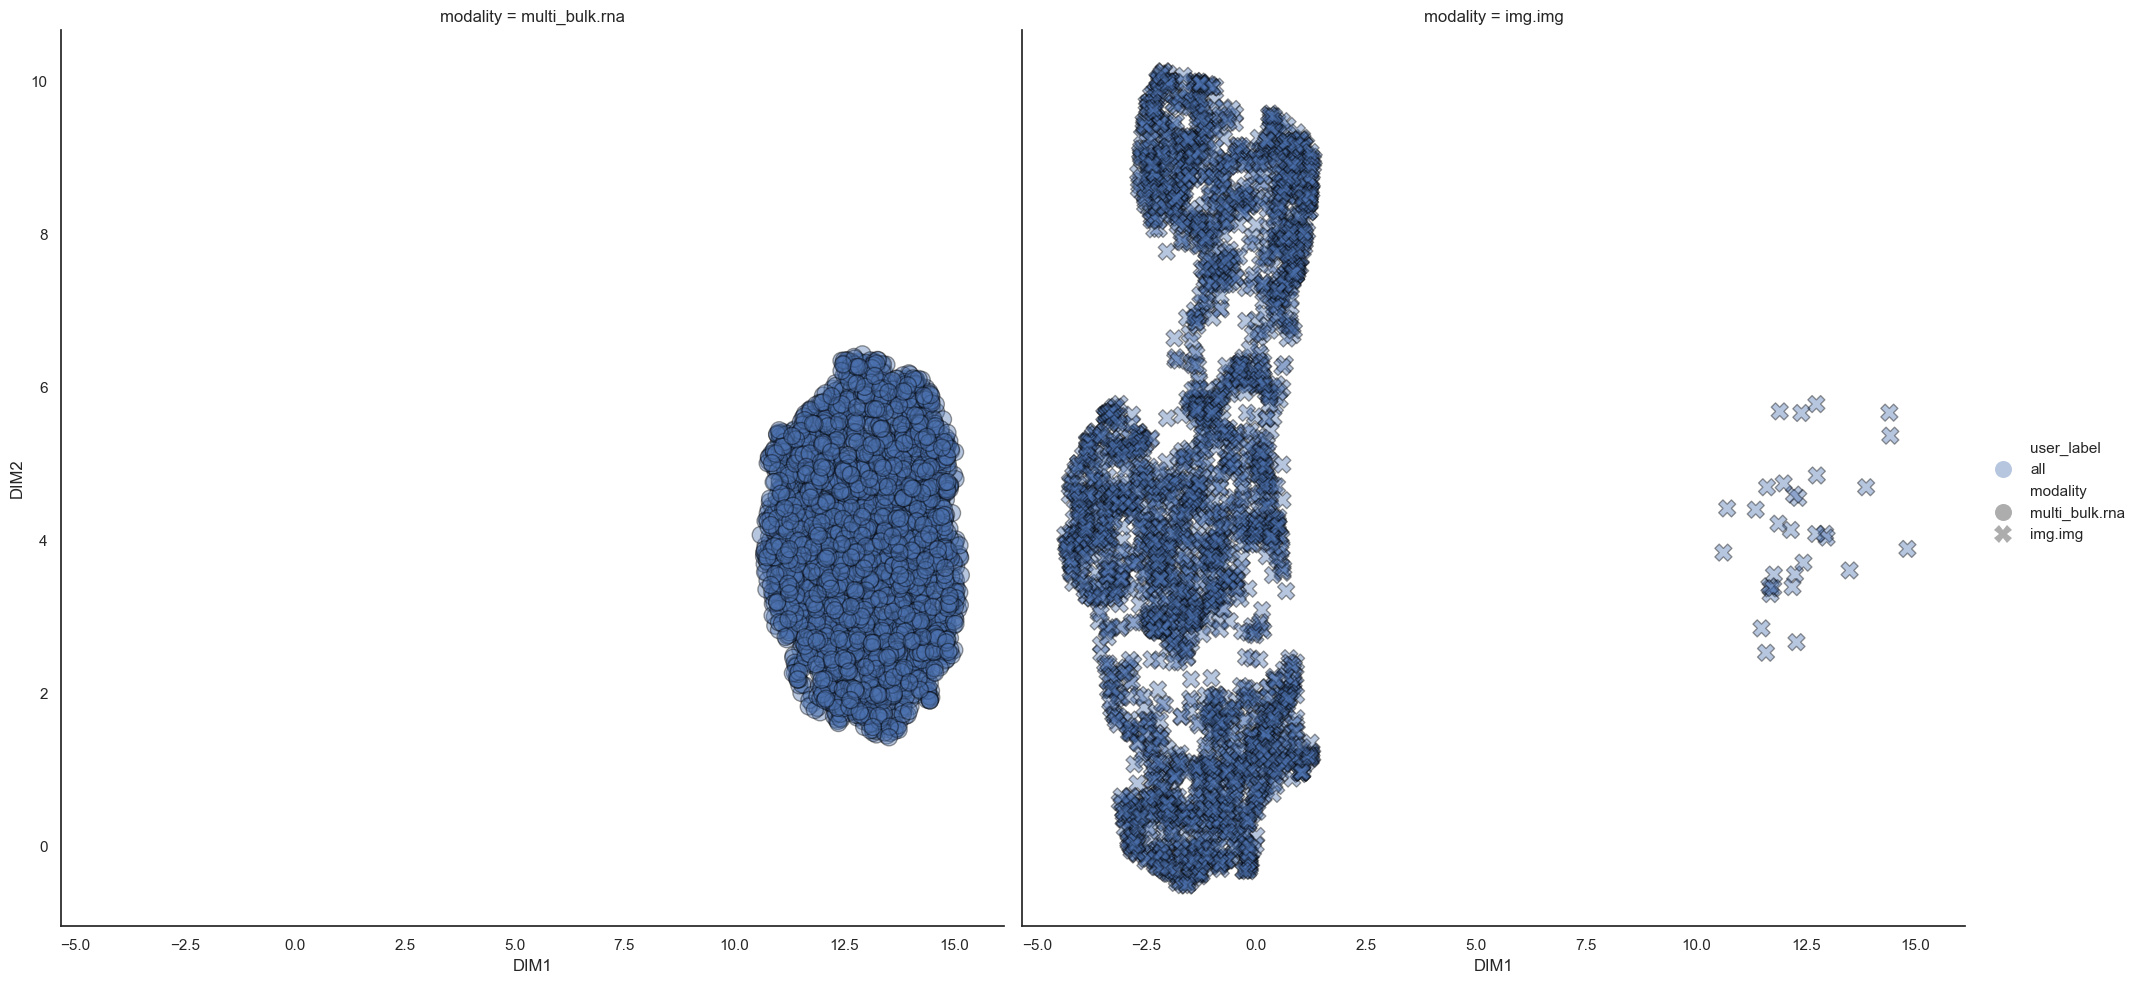

In [ ]:
xmodalix.show_result()

In [ ]:
import pandas as pd

anno_df = pd.read_csv(anno_file, sep="\t")
rna_df = pd.read_parquet(rna_file)


NameError: name 'anno_file' is not defined

In [ ]:
"TCGA-05-4244-01" in rna_df.index

True

In [ ]:
anno_df.head()

,sample_ids,img_paths,extra_class_labels,CANCER_TYPE_ACRONYM
0,TCGA-05-4244-01,0_label_1.png,Non-Small Cell Lung Cancer,LUAD
1,TCGA-05-4249-01,1_label_1.png,Non-Small Cell Lung Cancer,LUAD
2,TCGA-05-4250-01,2_label_1.png,Non-Small Cell Lung Cancer,LUAD
3,TCGA-05-4382-01,3_label_1.png,Non-Small Cell Lung Cancer,LUAD
4,TCGA-05-4384-01,4_label_1.png,Non-Small Cell Lung Cancer,LUAD


In [ ]:
for ind in rna_df.index:
    if "\n" in ind:
        print(ind)

In [ ]:
result = xmodalix.run()

reading parquet: data/XModalix-Tut-data/combined_rnaseq_formatted.parquet
Checking data type: img
Found image type in config
current data info: file_path='data/XModalix-Tut-data/images/tcga_fake' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=30
Checking data type: rna
Checking data type: anno
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/XModalix-Tut-data/tcga_mappings.txt
read annotation file in img reader:         sample_ids      img_paths          extra_class_labels  \
0  TCGA-05-4244-01  0_label_1.png  Non-Small Cell Lung Cancer   
1  TCGA-05-4249-01  1_label_1.png  Non-Small Cell Lung Cancer   
2  TCGA-05-4250-01  2_label_1.png  Non-Small Cell Lung Cancer   
3  TCGA-05-4382-01  3

KeyError: "None of [Index(['TCGA-N8-A4PM-01', 'TCGA-44-5643-01', 'TCGA-66-2765-01',\n       'TCGA-N6-A4VD-01', 'TCGA-LA-A7SW-01', 'TCGA-AA-A02J-01',\n       'TCGA-T9-A92H-01', 'TCGA-A6-5656-01', 'TCGA-AC-A3TN-01',\n       'TCGA-AM-5820-01',\n       ...\n       'TCGA-NH-A6GB-01', 'TCGA-XC-AA0X-01', 'TCGA-A8-A0A2-01',\n       'TCGA-22-5491-01', 'TCGA-E2-A15J-01', 'TCGA-23-1027-01',\n       'TCGA-D5-6539-01', 'TCGA-AR-A24Q-01', 'TCGA-D1-A1O5-01',\n       'TCGA-44-6775-01'],\n      dtype='object', length=2486)] are in the [index]"

In [ ]:
os.getcwd()

'/Users/maximilianjoas/development/autoencodix_package/Tutorials/PipelineTutorials'